In [11]:
import base64
import shutil
import IPython
import os
import json
import random
import numpy as np
import requests
from io import BytesIO
from math import trunc
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw

# COCO Image Viewer
This notebook will allow you to view details about a COCO dataset and preview segmentations on annotated images.
Learn more about it at: http://cocodataset.org/

In [12]:
# Load the dataset json
class CocoDataset():
    def __init__(self, annotation_path, image_dir):
        self.annotation_path = annotation_path
        self.image_dir = image_dir
        self.colors = ['blue', 'purple', 'red', 'green', 'orange', 'salmon', 'pink', 'gold',
                       'orchid', 'slateblue', 'limegreen', 'seagreen', 'darkgreen', 'olive',
                       'teal', 'aquamarine', 'steelblue', 'powderblue', 'dodgerblue', 'navy',
                       'magenta', 'sienna', 'maroon']

        json_file = open(self.annotation_path)
        self.coco = json.load(json_file)
        json_file.close()

        self.process_info()
        self.process_licenses()
        self.process_categories()
        self.process_images()
        self.process_segmentations()

    def display_info(self):
        print('Dataset Info:')
        print('=============')
        if self.info is None:
            return
        for key, item in self.info.items():
            print('  {}: {}'.format(key, item))

        requirements = [['description', str],
                        ['url', str],
                        ['version', str],
                        ['year', int],
                        ['contributor', str],
                        ['date_created', str]]
        for req, req_type in requirements:
            if req not in self.info:
                print('ERROR: {} is missing'.format(req))
            elif type(self.info[req]) != req_type:
                print('ERROR: {} should be type {}'.format(req, str(req_type)))
        print('')

    def display_licenses(self):
        print('Licenses:')
        print('=========')

        if self.licenses is None:
            return
        requirements = [['id', int],
                        ['url', str],
                        ['name', str]]
        for license in self.licenses:
            for key, item in license.items():
                print('  {}: {}'.format(key, item))
            for req, req_type in requirements:
                if req not in license:
                    print('ERROR: {} is missing'.format(req))
                elif type(license[req]) != req_type:
                    print('ERROR: {} should be type {}'.format(
                        req, str(req_type)))
            print('')
        print('')

    def display_categories(self):
        print('Categories:')
        print('=========')
        for sc_key, sc_val in self.super_categories.items():
            print('  super_category: {}'.format(sc_key))
            for cat_id in sc_val:
                print('    id {}: {}'.format(
                    cat_id, self.categories[cat_id]['name']))
            print('')

    def display_image(self, image_id, show_polys=True, show_bbox=True, show_crowds=True, use_url=False):
        print('Image:')
        print('======')
        if image_id == 'random':
            image_id = random.choice(list(self.images.keys()))

        # Print the image info
        image = self.images[image_id]
        for key, val in image.items():
            print('  {}: {}'.format(key, val))

        # Open the image
        if use_url:
            image_path = image['coco_url']
            response = requests.get(image_path)
            image = PILImage.open(BytesIO(response.content))

        else:
            # image_path = os.path.join(self.image_dir, image['file_name'])
            image_path = "{}/{}".format(self.image_dir, image['file_name'])
            image = PILImage.open(image_path)

        # Create the image
        buffer = BytesIO()
        image.save(buffer, format='PNG')
        buffer.seek(0)
        data_uri = base64.b64encode(buffer.read()).decode('ascii')
        image_path = "data:image/png;base64,{0}".format(data_uri)

        # Calculate the size and adjusted display size
        max_width = 600
        image_width, image_height = image.size
        adjusted_width = min(image_width, max_width)
        adjusted_ratio = adjusted_width / image_width
        adjusted_height = adjusted_ratio * image_height

        # Create list of polygons to be drawn
        polygons = {}
        bbox_polygons = {}
        rle_regions = {}
        poly_colors = {}
        bbox_categories = {}
        print('  segmentations ({}):'.format(
            len(self.segmentations[image_id])))
        for i, segm in enumerate(self.segmentations[image_id]):
            polygons_list = []
            if segm['iscrowd'] != 0:
                # Gotta decode the RLE
                px = 0
                x, y = 0, 0
                rle_list = []
                for j, counts in enumerate(segm['segmentation']['counts']):
                    if j % 2 == 0:
                        # Empty pixels
                        px += counts
                    else:
                        # Need to draw on these pixels, since we are drawing in vector form,
                        # we need to draw horizontal lines on the image
                        x_start = trunc(
                            trunc(px / image_height) * adjusted_ratio)
                        y_start = trunc(px % image_height * adjusted_ratio)
                        px += counts
                        x_end = trunc(trunc(px / image_height)
                                      * adjusted_ratio)
                        y_end = trunc(px % image_height * adjusted_ratio)
                        if x_end == x_start:
                            # This is only on one line
                            rle_list.append(
                                {'x': x_start, 'y': y_start, 'width': 1, 'height': (y_end - y_start)})
                        if x_end > x_start:
                            # This spans more than one line
                            # Insert top line first
                            rle_list.append(
                                {'x': x_start, 'y': y_start, 'width': 1, 'height': (image_height - y_start)})

                            # Insert middle lines if needed
                            lines_spanned = x_end - x_start + 1  # total number of lines spanned
                            full_lines_to_insert = lines_spanned - 2
                            if full_lines_to_insert > 0:
                                full_lines_to_insert = trunc(
                                    full_lines_to_insert * adjusted_ratio)
                                rle_list.append(
                                    {'x': (x_start + 1), 'y': 0, 'width': full_lines_to_insert, 'height': image_height})

                            # Insert bottom line
                            rle_list.append(
                                {'x': x_end, 'y': 0, 'width': 1, 'height': y_end})
                if len(rle_list) > 0:
                    rle_regions[segm['id']] = rle_list
            else:
                # Add the polygon segmentation
                for segmentation_points in segm['segmentation']:
                    segmentation_points = np.multiply(
                        segmentation_points, adjusted_ratio).astype(int)
                    polygons_list.append(
                        str(segmentation_points).lstrip('[').rstrip(']'))
            polygons[segm['id']] = polygons_list
            if i < len(self.colors):
                poly_colors[segm['id']] = self.colors[i]
            else:
                poly_colors[segm['id']] = 'white'

            bbox = segm['bbox']
            bbox_points = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1],
                           bbox[0] + bbox[2], bbox[1] +
                           bbox[3], bbox[0], bbox[1] + bbox[3],
                           bbox[0], bbox[1]]
            bbox_points = np.multiply(bbox_points, adjusted_ratio).astype(int)
            bbox_polygons[segm['id']] = str(
                bbox_points).lstrip('[').rstrip(']')
            bbox_categories[segm['id']] = self.categories[segm['category_id']]
            # Print details
            print('    {}:{}:{}'.format(
                segm['id'], poly_colors[segm['id']], self.categories[segm['category_id']]))

        # Draw segmentation polygons on image
        html = '<div class="container" style="position:relative;">'
        html += '<img src="{}" style="position:relative;top:0px;left:0px;width:{}px;">'.format(
            image_path, adjusted_width)
        html += '<div class="svgclass"><svg width="{}" height="{}">'.format(
            adjusted_width, adjusted_height)

        if show_polys:
            for seg_id, points_list in polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for points in points_list:
                    html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5" />'.format(
                        points, fill_color, stroke_color)

        if show_crowds:
            for seg_id, rect_list in rle_regions.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for rect_def in rect_list:
                    x, y = rect_def['x'], rect_def['y']
                    w, h = rect_def['width'], rect_def['height']
                    html += '<rect x="{}" y="{}" width="{}" height="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5; stroke-opacity:0.5" />'.format(
                        x, y, w, h, fill_color, stroke_color)

        if show_bbox:
            for seg_id, points in bbox_polygons.items():
                x, y = [int(i) for i in points.split()[:2]]
                html += '<text x="{}" y="{}" fill="yellow">{}</text>'.format(
                    x, y, bbox_categories[seg_id]["name"])
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0" />'.format(
                    points, fill_color, stroke_color)

        html += '</svg></div>'
        html += '</div>'
        html += '<style>'
        html += '.svgclass { position:absolute; top:0px; left:0px;}'
        html += '</style>'
        return html

    def process_info(self):
        self.info = self.coco.get('info')

    def process_licenses(self):
        self.licenses = self.coco.get('licenses')

    def process_categories(self):
        self.categories = {}
        self.super_categories = {}
        for category in self.coco['categories']:
            cat_id = category['id']
            super_category = category['name']

            # Add category to the categories dict
            if cat_id not in self.categories:
                self.categories[cat_id] = category
            else:
                print("ERROR: Skipping duplicate category id: {}".format(category))

            # Add category to super_categories dict
            if super_category not in self.super_categories:
                # Create a new set with the category id
                self.super_categories[super_category] = {cat_id}
            else:
                self.super_categories[super_category] |= {
                    cat_id}  # Add category id to the set

    def process_images(self):
        self.images = {}
        for image in self.coco['images']:
            image_id = image['id']
            if image_id in self.images:
                print("ERROR: Skipping duplicate image id: {}".format(image))
            else:
                self.images[image_id] = image

    def process_segmentations(self):
        self.segmentations = {}
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)

In [13]:
annotation_path = "./outputscoco/annotations/instances_train2020.json"
image_dir = "./outputscoco/images/train2020"

coco_dataset = CocoDataset(annotation_path, image_dir)
#coco_dataset.display_info()
coco_dataset.display_licenses()
coco_dataset.display_categories()

Licenses:
Categories:
  super_category: __background__
    id 0: __background__

  super_category: 1
    id 1: 1

  super_category: 2
    id 2: 2

  super_category: 3
    id 3: 3

  super_category: 4
    id 4: 4

  super_category: 5
    id 5: 5



In [14]:
for k, v in coco_dataset.images.items():
    print(k, v)

0 {'height': 1024, 'width': 1024, 'id': 0, 'file_name': '1571.tif'}
1 {'height': 1024, 'width': 1024, 'id': 1, 'file_name': '1457.tif'}
2 {'height': 1024, 'width': 1024, 'id': 2, 'file_name': '868.tif'}
3 {'height': 1024, 'width': 1024, 'id': 3, 'file_name': '239.tif'}
4 {'height': 1024, 'width': 1024, 'id': 4, 'file_name': '857.tif'}
5 {'height': 1024, 'width': 1024, 'id': 5, 'file_name': '1480.tif'}
6 {'height': 1024, 'width': 1024, 'id': 6, 'file_name': '376.tif'}
7 {'height': 1024, 'width': 1024, 'id': 7, 'file_name': '378.tif'}
8 {'height': 1024, 'width': 1024, 'id': 8, 'file_name': '1276.tif'}
9 {'height': 1024, 'width': 1024, 'id': 9, 'file_name': '587.tif'}
10 {'height': 1024, 'width': 1024, 'id': 10, 'file_name': '1636.tif'}
11 {'height': 1024, 'width': 1024, 'id': 11, 'file_name': '1577.tif'}
12 {'height': 1024, 'width': 1024, 'id': 12, 'file_name': '775.tif'}
13 {'height': 1024, 'width': 1024, 'id': 13, 'file_name': '1045.tif'}
14 {'height': 1024, 'width': 1024, 'id': 14, 'f

1284 {'height': 1024, 'width': 1024, 'id': 1284, 'file_name': '1209.tif'}
1285 {'height': 1024, 'width': 1024, 'id': 1285, 'file_name': '884.tif'}
1286 {'height': 1024, 'width': 1024, 'id': 1286, 'file_name': '1164.tif'}
1287 {'height': 1024, 'width': 1024, 'id': 1287, 'file_name': '656.tif'}
1288 {'height': 1024, 'width': 1024, 'id': 1288, 'file_name': '1361.tif'}
1289 {'height': 1024, 'width': 1024, 'id': 1289, 'file_name': '54.tif'}
1290 {'height': 1024, 'width': 1024, 'id': 1290, 'file_name': '68.tif'}
1291 {'height': 1024, 'width': 1024, 'id': 1291, 'file_name': '627.tif'}
1292 {'height': 1024, 'width': 1024, 'id': 1292, 'file_name': '1962.tif'}
1293 {'height': 1024, 'width': 1024, 'id': 1293, 'file_name': '67.tif'}
1294 {'height': 1024, 'width': 1024, 'id': 1294, 'file_name': '215.tif'}
1295 {'height': 1024, 'width': 1024, 'id': 1295, 'file_name': '213.tif'}
1296 {'height': 1024, 'width': 1024, 'id': 1296, 'file_name': '1303.tif'}
1297 {'height': 1024, 'width': 1024, 'id': 1297, 

Image:
  height: 1024
  width: 1024
  id: 1
  file_name: 1457.tif
  segmentations (4):
    1:blue:{'id': 2, 'name': '2'}
    2:purple:{'id': 2, 'name': '2'}
    3:red:{'id': 5, 'name': '5'}
    4:green:{'id': 2, 'name': '2'}



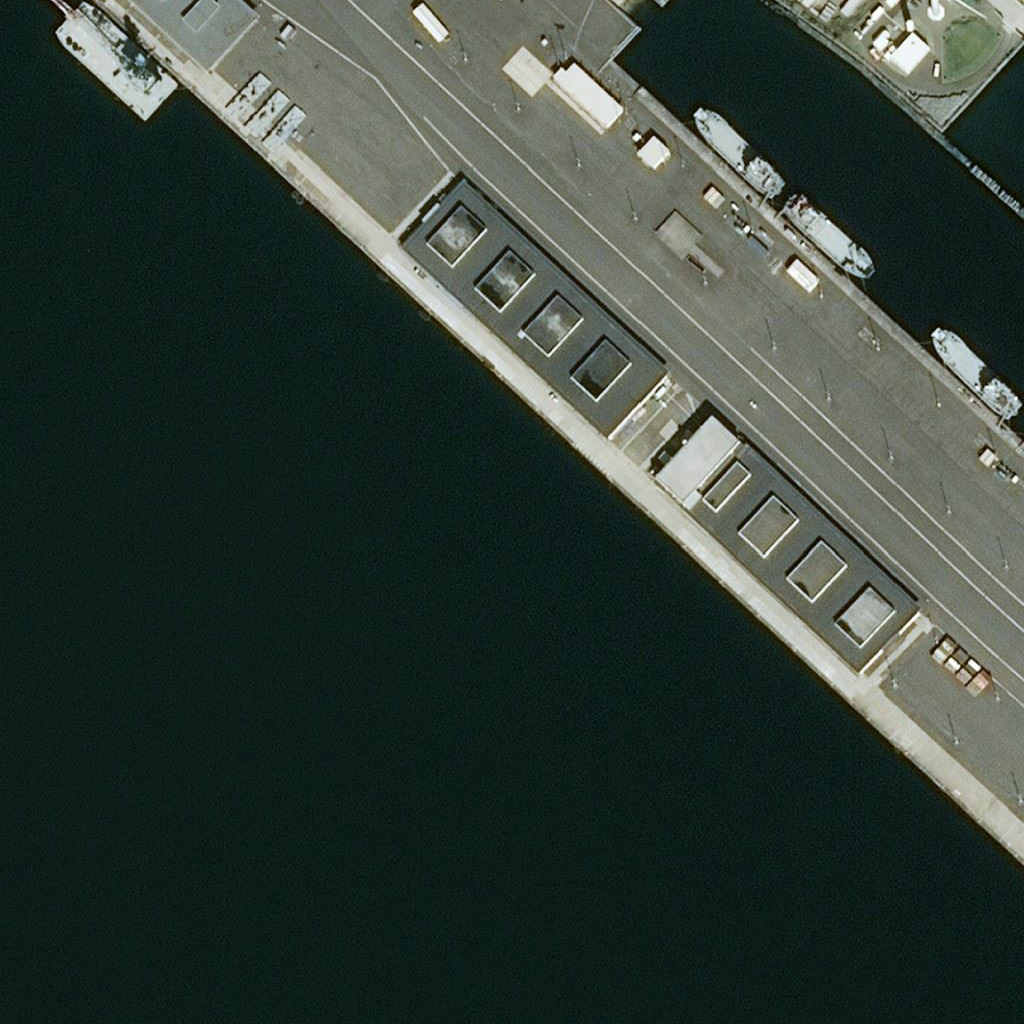

In [17]:
html = coco_dataset.display_image(1, use_url=False)
IPython.display.HTML(html)


Image:
  height: 1024
  width: 1024
  id: 6
  file_name: 376.tif
  segmentations (2):
    15:blue:{'id': 5, 'name': '5'}
    16:purple:{'id': 4, 'name': '4'}



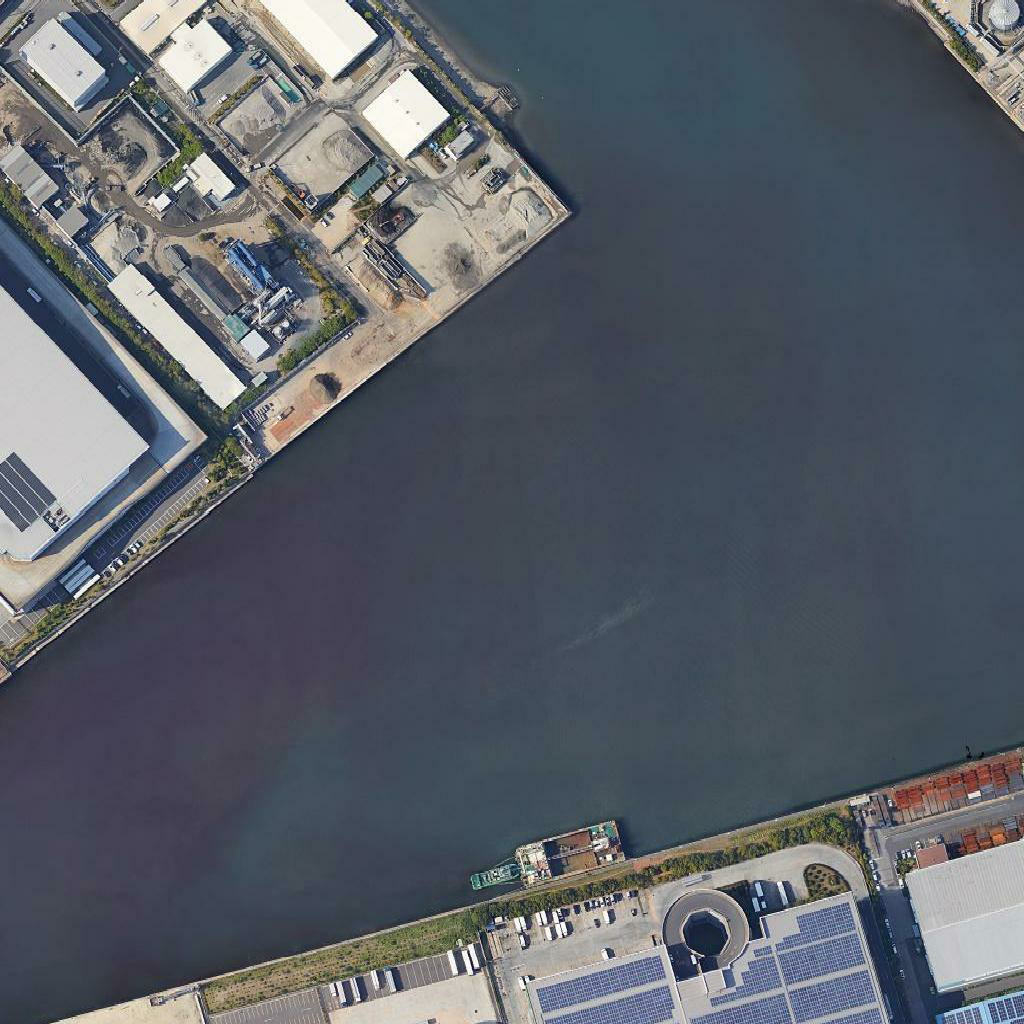

In [16]:
html = coco_dataset.display_image(6, use_url=False)
IPython.display.HTML(html)